In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import random_split

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tempfile
import os

from ray import tune
from ray.train import Checkpoint, get_checkpoint, report
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

2024-10-08 16:36:28,043	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-08 16:36:28,855	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
train_and_validate_dataset = FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
csv_train = pd.read_csv('data/fashion-mnist_train.csv')
csv_test = pd.read_csv('data/fashion-mnist_test.csv')

Exploratory Data Analysis

In [4]:
#Classes:
classes = train_and_validate_dataset.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
csv_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each dataframe is class (from 0 to 9) and 28*28 monohrome pixels.

Amount of dataframes in train, test datasets

In [6]:
print("Train dataset size:", len(csv_train))
print("Test dataset size:", len(csv_test))

Train dataset size: 60000
Test dataset size: 10000


In [7]:
def show_image(dataset: FashionMNIST, index: int):
    figure = plt.figure(figsize = (5,5))
    image, label = dataset[index]
    plt.title(dataset.classes[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    

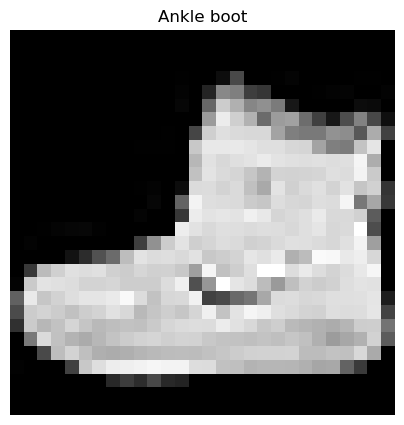

In [8]:
#Example of image
show_image(train_and_validate_dataset, 0)

Class distribution

In [9]:
def get_classes_distribution(frames: pd.DataFrame, classes: list[str]):
    value_counts = frames['label'].value_counts()
    total_amount = len(frames)
    for i in range(len(value_counts)):
        label = classes[value_counts.index[i]]
        amount = value_counts.values[i]
        percentage = amount * 100 / total_amount
        print("#{} {:<15s}:   {} or {}%".format(value_counts.index[i], label, amount, percentage))


In [10]:
print("Train set class distribution")
get_classes_distribution(csv_train, classes)


Train set class distribution
#2 Pullover       :   6000 or 10.0%
#9 Ankle boot     :   6000 or 10.0%
#6 Shirt          :   6000 or 10.0%
#0 T-shirt/top    :   6000 or 10.0%
#3 Dress          :   6000 or 10.0%
#4 Coat           :   6000 or 10.0%
#5 Sandal         :   6000 or 10.0%
#8 Bag            :   6000 or 10.0%
#7 Sneaker        :   6000 or 10.0%
#1 Trouser        :   6000 or 10.0%


In [11]:
print("Test set class distribution")
get_classes_distribution(csv_test, classes)

Test set class distribution
#0 T-shirt/top    :   1000 or 10.0%
#1 Trouser        :   1000 or 10.0%
#2 Pullover       :   1000 or 10.0%
#3 Dress          :   1000 or 10.0%
#8 Bag            :   1000 or 10.0%
#6 Shirt          :   1000 or 10.0%
#5 Sandal         :   1000 or 10.0%
#4 Coat           :   1000 or 10.0%
#7 Sneaker        :   1000 or 10.0%
#9 Ankle boot     :   1000 or 10.0%


In [12]:
def construct_conv_layers(conv1_out, conv1_kernel_size, conv2_out, conv2_kernel_size):
    conv2_in = conv1_out 
    return nn.ParameterList([
        nn.Conv2d(in_channels=1, out_channels=conv1_out, kernel_size=conv1_kernel_size),
        nn.Conv2d(in_channels=conv2_in, out_channels=conv2_out, kernel_size=conv2_kernel_size)
    ])

def construct_fc_layers(after_conv_size, fc1_out, fc2_out, classes_amount):
    return nn.ParameterList([
        nn.Linear(in_features=after_conv_size, out_features=fc1_out),
        nn.Linear(in_features=fc1_out, out_features=fc2_out),
        nn.Linear(in_features=fc2_out, out_features=classes_amount)
    ])

def kernel_size_reduction(kernel_size: int):
    return (kernel_size - 1)

In [13]:
class MLP(nn.Module): 
    def __init__(self, conv1_out, conv1_kernel_size, conv2_out, conv2_kernel_size, fc1_out, fc2_out, image_size = 28, classes_amount = 10):
        super().__init__()
        self.conv_layers = construct_conv_layers(conv1_out, conv1_kernel_size, conv2_out, conv2_kernel_size)
        self.activation = nn.functional.relu
        self.after_conv_size = (image_size - kernel_size_reduction(conv1_kernel_size) - kernel_size_reduction(conv2_kernel_size))**2 * conv2_out
        self.pool = nn.functional.adaptive_avg_pool2d
        self.fully_connected_layers = construct_fc_layers(self.after_conv_size, fc1_out, fc2_out, classes_amount)


    def forward(self, x):
        for i in range(len(self.conv_layers)):
            conv_l = self.conv_layers[i]
            x = conv_l(x)
            x = self.activation(x)
            x = self.pool(x, output_size=x.shape[2])
        
        x = x.view(-1, self.after_conv_size)
        
        for i in range(len(self.fully_connected_layers)):
            fc_l = self.fully_connected_layers[i]
            x = fc_l(x)
            if i + 1 != len(self.fully_connected_layers):
                x = self.activation(x)
        
        return x
    

In [14]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

train_data, validate_data = random_split(dataset=train_and_validate_dataset, lengths=[0.8, 0.2])
test_data = test_dataset

In [75]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X)

def evaluate(model, loader):
    model.eval()
    
    accuracy_by_class = np.zeros(10)

    with torch.no_grad():
        losses = []
        correct = 0
        length = 0

        for x, y in loader:
            loss_, correct_, len_ = validate(model, nn.CrossEntropyLoss(), x, y)
            losses.append(np.multiply(loss_, len_))
            correct += correct_
            # works only with batch_size = 0
            accuracy_by_class[y[0].item()] += correct_
            length += len_
        test_loss = np.sum(losses) / length
        test_accuracy = correct / length * 100

        print(f"Test loss: {test_loss:.5f}\t"
          f"Test accuracy: {test_accuracy:.3f}%")
        # print(accuracy_by_class)
        return accuracy_by_class

In [48]:
def train(config, report_func=report): 
    conv1_out = config["conv2_out"] if config["conv1_out"] < config["conv2_out"] else config["conv1_out"]
    conv2_out = config["conv1_out"] if config["conv1_out"] < config["conv2_out"] else config["conv2_out"]
    fc1_out = config["fc2_out"] if config["fc1_out"] < config["fc2_out"] else config["fc1_out"]
    fc2_out = config["fc1_out"] if config["fc1_out"] < config["fc2_out"] else config["fc2_out"]

    if (28 - config["conv1_kernel_size"] - config["conv2_kernel_size"] + 2) >= fc1_out:
        raise BaseException("incorrect params")
    
    model = MLP(conv1_out=conv1_out, conv1_kernel_size=config["conv1_kernel_size"],
                conv2_out=conv2_out, conv2_kernel_size=config["conv2_kernel_size"],
                fc1_out=fc1_out, fc2_out=fc2_out).to(device=device)
    patience = 5
    epochs = 40
    optimizer = torch.optim.Adam(model.parameters(), lr = config["lr"])

    train_loader = WrappedDataLoader(DataLoader(train_data, batch_size = int(config["batch_size"])), to_device)
    validate_loader = WrappedDataLoader(DataLoader(validate_data, batch_size = int(config["batch_size"])), to_device)
    
    loss_min = np.Inf
    wait = 0

    if get_checkpoint():
        loaded_checkpoint = get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    for epoch in range(epochs):
        model.train()

        losses = []
        length = 0
        for tr_x, tr_y in train_loader:
            loss_, len_ = loss(model, nn.CrossEntropyLoss(), tr_x, tr_y, optimizer)
            losses.append(np.multiply(loss_, len_))
            length += len_
        train_loss = np.sum(losses) / length
        model.eval()

        with torch.no_grad(), tempfile.TemporaryDirectory() as temp_checkpoint_dir:

            losses = []
            correct = 0
            length = 0
            for v_x, v_y in validate_loader:
                loss_, correct_, len_ = validate(model=model, loss_func=nn.CrossEntropyLoss(), X=v_x, y=v_y)
                losses.append(np.multiply(loss_, len_))
                correct += correct_
                length += len_
            valid_loss = sum(losses) / length
            valid_accuracy = correct / length

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accuracy: {(valid_accuracy * 100):.3f}%")

            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            report_func(
                {"loss": valid_loss, "accuracy": valid_accuracy},
                checkpoint=checkpoint,
            )

            # Save model if validation loss has decreased
            if valid_loss <= loss_min:
                # print(f"Validation loss decreased ({loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                # torch.save(model.state_dict(), model_name + '.pt')
                loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return
        
        



        


In [47]:
batch_size_scope = [2, 4, 8, 16, 32]
kernel_size_scope = [3, 5]
conv_size_scope = [4, 8, 16, 32, 64, 128]
fc_size_scope = [16, 32, 64, 128]
config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice(batch_size_scope),
    "conv1_kernel_size": tune.choice(kernel_size_scope),
    "conv2_kernel_size": tune.choice(kernel_size_scope),
    "conv1_out": tune.choice(conv_size_scope),
    "conv2_out": tune.choice(conv_size_scope),
    "fc1_out": tune.choice(fc_size_scope),
    "fc2_out": tune.choice(fc_size_scope)
}

In [37]:
def test_best_model(checkpoint_dir, config):
    best_trained_model = MLP(conv1_out=config["conv1_out"], conv1_kernel_size=config["conv1_kernel_size"],
                conv2_out=config["conv2_out"], conv2_kernel_size=config["conv2_kernel_size"],
                fc1_out=config["fc1_out"], fc2_out=config["fc2_out"]).to(device=device)

    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    test_loader = WrappedDataLoader(DataLoader(test_data, batch_size = 1), to_device)
    return evaluate(model=best_trained_model, loader=test_loader)

In [20]:
from ray.tune.search.ax import AxSearch

def train_model(num_samples=128, max_num_epochs=40, gpus_per_trial=0.125):
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    ax_search = AxSearch(parameter_constraints=[
        "conv1_out >= conv2_out",
        "28 - conv1_kernel_size - conv2_kernel_size + 2 >= fc1_out",
        "fc1_out >= fc2_out",
        "fc2_out >= 10"
    ])
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train),
            resources={"cpu": 0.5, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
            # search_alg=ax_search
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))
    test_best_model(config=best_result.config, checkpoint_dir=best_result.checkpoint.to_directory())

    # check_point = torch.load(model_name + '.pt', map_location=device)
    # model.load_state_dict(check_point)
    
    
    


[WARNING 10-08 16:36:41] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [ ]:
train_model()

Best parameters were found by running 128 runs. It took 3 hours.

In [74]:
best_config = {
    "lr": 0.00031588,
    "batch_size": 16,
    "conv1_kernel_size": 3,
    "conv2_kernel_size": 3,
    "conv1_out": 64,
    "conv2_out": 32,
    "fc1_out": 64,
    "fc2_out": 32
}

accuracy_by_label = test_best_model(checkpoint_dir="./", config = best_config)


C:\Users\pc\AppData\Local\Temp\ipykernel_12132\1417129821.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state, optimizer_state = torch.load(checkpoint_path)


Test loss: 0.32118	Test accuracy: 88.920%
[818. 971. 875. 871. 884. 977. 610. 958. 983. 945.]


In [41]:
for i in range(len(accuracy_by_label)):
    print(f"{classes[i]}:   {accuracy_by_label[i]/10}%")

T-shirt/top:   81.8%
Trouser:   97.1%
Pullover:   87.5%
Dress:   87.1%
Coat:   88.4%
Sandal:   97.7%
Shirt:   61.0%
Sneaker:   95.8%
Bag:   98.3%
Ankle boot:   94.5%


Model recognizes bag, trousers, sandals the best.
Model recognizes shirts the worst

In [55]:
runs = []
def my_report(metrics: dict, checkpoint: Checkpoint):
    loss = metrics["loss"]
    accuracy = metrics["accuracy"]
    runs.append({"loss": loss, "accuracy": accuracy, "checkpoint": checkpoint})

def explore_adjacent_to_best(best_config, variable_parameter: str, scope: list):
    best_runs = []
    for i in range(len(scope)):
        new_config = best_config.copy()
        new_config[variable_parameter] = scope[i]
        train(new_config, report_func=my_report)
        best_runs.append(runs[-1])
    return best_runs

In [ ]:
conv1_runs = explore_adjacent_to_best(best_config, "conv1_out", conv_size_scope)

In [72]:
def show_impact(scope: list, runs: list, x_label, property="accuracy"): 
    fig = plt.figure(figsize = (5, 5))
    y = list(map(lambda data: data[property], runs))
    plt.bar(scope, y, color ='maroon', width = np.average(scope)/20)
    plt.xticks(scope, scope)
    plt.xlabel(x_label)
    plt.ylabel(property)
    plt.title(property + " dependency on '"+x_label+"' parameter")
    plt.show()

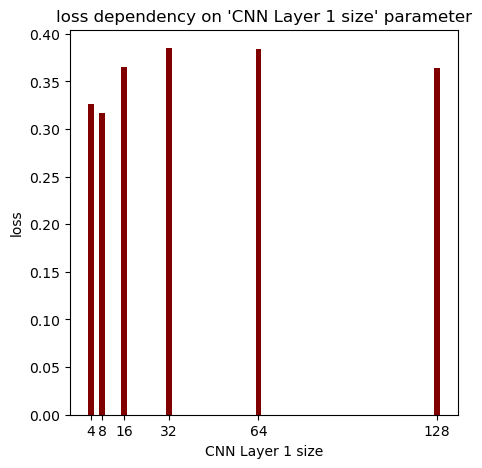

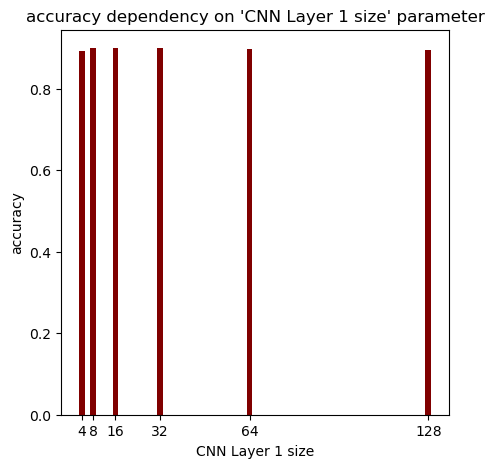

In [87]:
show_impact(conv_size_scope, conv1_runs, "CNN Layer 1 size", "loss")
show_impact(conv_size_scope, conv1_runs, "CNN Layer 1 size", "accuracy")

In [ ]:
conv2_runs = explore_adjacent_to_best(best_config, "conv2_out", conv_size_scope)
conv2_runs

In [26]:
def show_impact(scope: list, runs: list, x_label, property="accuracy"): 
    fig = plt.figure(figsize = (5, 5))
    y = list(map(lambda data: data[property], runs))
    plt.bar(scope, y, color ='maroon', width = np.average(scope)/20)
    plt.xticks(scope, scope)
    plt.xlabel(x_label)
    plt.ylabel(property)
    plt.title(property + " dependency on '"+x_label+"' parameter")
    plt.show()

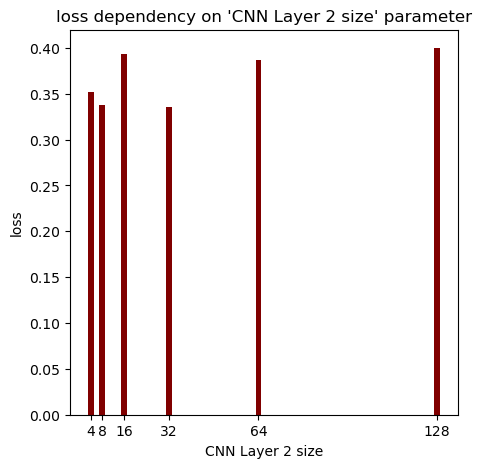

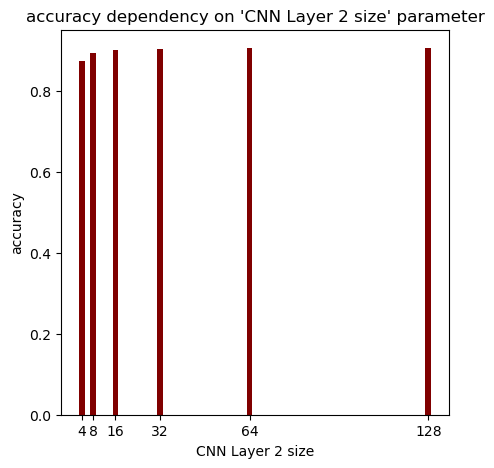

In [28]:
conv2_runs = explore_adjacent_to_best(best_config, "conv2_out", conv_size_scope)
show_impact(conv_size_scope, conv2_runs, "CNN Layer 2 size", "loss")
show_impact(conv_size_scope, conv2_runs, "CNN Layer 2 size", "accuracy")

In [ ]:
fc1_runs = explore_adjacent_to_best(best_config, "fc1_out", fc_size_scope)

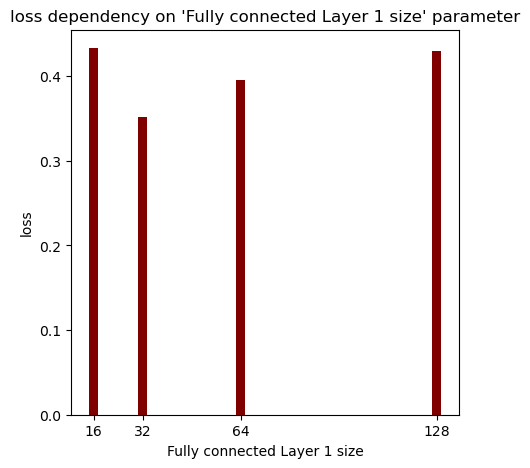

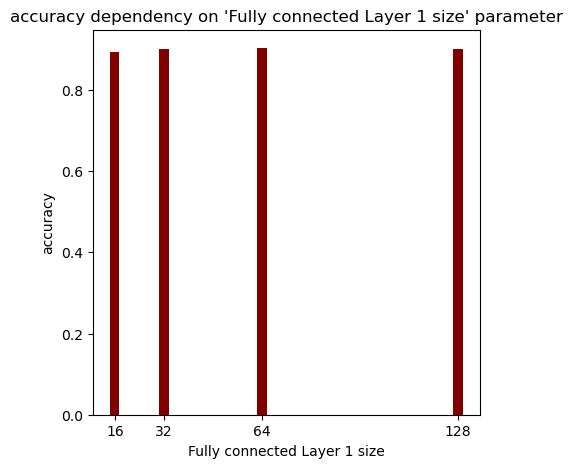

In [ ]:
show_impact(fc_size_scope, fc1_runs, "Fully connected Layer 1 size", "loss")
show_impact(fc_size_scope, fc1_runs, "Fully connected Layer 1 size", "accuracy")

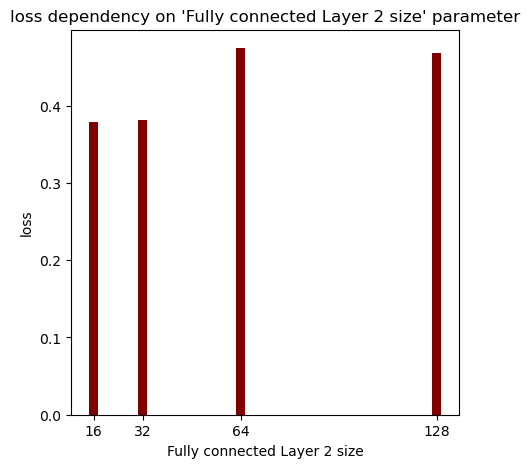

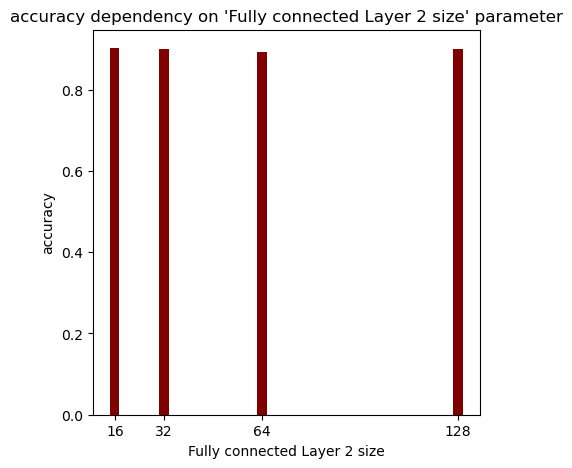

In [ ]:
fc2_runs = explore_adjacent_to_best(best_config, "fc2_out", fc_size_scope)
show_impact(fc_size_scope, fc2_runs, "Fully connected Layer 2 size", "loss")
show_impact(fc_size_scope, fc2_runs, "Fully connected Layer 2 size", "accuracy")

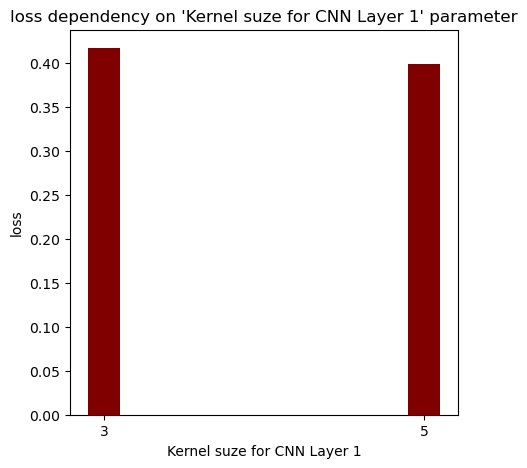

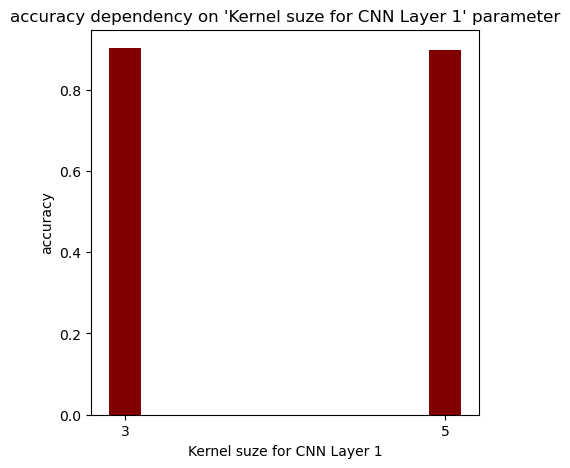

In [ ]:
kernel1_runs = explore_adjacent_to_best(best_config, "conv1_kernel_size", kernel_size_scope)
show_impact(kernel_size_scope, kernel1_runs, "Kernel suze for CNN Layer 1", "loss")
show_impact(kernel_size_scope, kernel1_runs, "Kernel suze for CNN Layer 1", "accuracy")

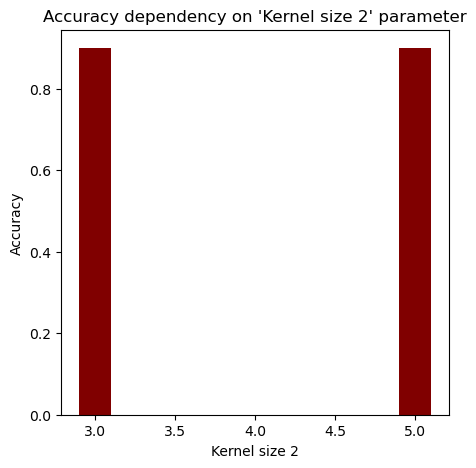

In [42]:
kernel2_runs = explore_adjacent_to_best(best_config, "conv2_kernel_size", kernel_size_scope)
show_impact(kernel_size_scope, kernel2_runs, "Kernel suze for CNN Layer 2", "loss")
show_impact(kernel_size_scope, kernel2_runs, "Kernel suze for CNN Layer 2", "accuracy")